In [1]:
import os
import random

import pandas as pd
import numpy as np

import colorsys
import cv2
import albumentations as A
from tqdm.auto import tqdm

import torch

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [3]:
def decode_rle_mask(rle_mask, shape=(520, 704)):

    """
    Decode run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    rle_mask (str): Run-length encoded segmentation mask string
    shape (tuple): Height and width of the mask

    Returns
    -------
    mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    """

    rle_mask = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_mask[0:][::2], rle_mask[1:][::2])]
    starts -= 1
    ends = starts + lengths

    mask = np.zeros((shape[0] * shape[1]), dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    mask = mask.reshape(shape[0], shape[1])
    mask = np.uint8(mask)
    return mask


def encode_rle_mask(mask, shape=(520, 704)):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 1
    rle[1::2] -= rle[::2]
    return rle.tolist()

In [4]:
def get_bboxes_from_mask(masks):
    coco_boxes = []
    for mask in masks:
        pos = np.nonzero(mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        coco_boxes.append([xmin, ymin, xmax, ymax])
    coco_boxes = np.asarray(coco_boxes)
    return coco_boxes

In [5]:
def get_targets_mask(df, img_id):
    targets = df[df['id'] == img_id]['cell_type'].apply(lambda x: cls_map[x]).values
    rles = df[df['id'] == img_id]['annotation'].values
    return targets, rles

In [6]:
train_df = pd.read_csv('data/train.csv')

In [7]:
cls_map = {value:idx for idx, value in enumerate(train_df['cell_type'].unique())}
cls_map_reversed = {cls_map[key]: key for key in cls_map.keys()}

In [8]:
img_id = train_df.iloc[0]['id']
img = cv2.imread(f'data/train/{img_id}.png')

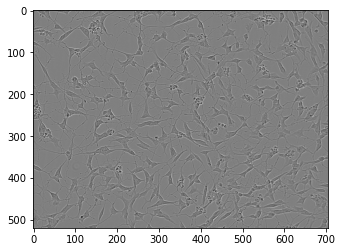

In [9]:
plt.imshow(img)

In [10]:
labels, rles = get_targets_mask(train_df, img_id)

In [11]:
len(rles)

395

In [12]:
mask = decode_rle_mask(rles[0])

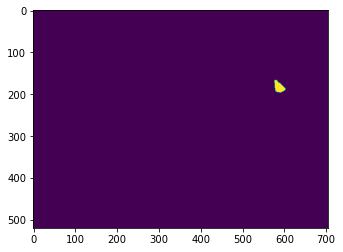

In [13]:
plt.imshow(mask)

In [14]:
mask.flatten()[1::2].shape

(183040,)

In [15]:
mask.flatten().shape

(366080,)

In [16]:
mask = decode_rle_mask(str(encode_rle_mask(mask)).replace('[', '').replace(']', '').replace(',', ''))

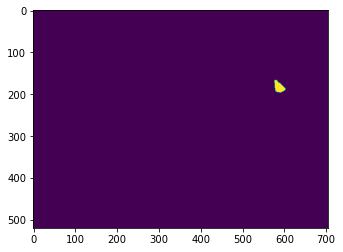

In [17]:
plt.imshow(mask)

In [18]:
masks = []
for mask in train_df.loc[train_df['id'] == img_id, 'annotation'].values:
    decoded_mask = decode_rle_mask(rle_mask=mask, shape=img.shape)
    masks.append(decoded_mask)

In [19]:
# masks = np.stack(masks)

In [20]:
bboxes = get_bboxes_from_mask(masks)

In [21]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [22]:
def plot_image_annotations(image, masks, bboxes, labels, aug=None):
    image = image.copy()
    
    colors = {unique_lbl:random_colors(1, True)[0] for unique_lbl in np.unique(labels)}
    
    if aug is not None:
        augmented = aug(image=image, masks=masks, bboxes=bboxes,
                        labels=labels)
        image = augmented['image']
        masks = augmented['masks']
        bboxes = augmented['bboxes']
    
    bboxes = np.stack(bboxes).astype(int)
        
    for idx, box in enumerate(bboxes):
        color = tuple([int(value*255) for value in colors[labels[idx]]])
        image = cv2.rectangle(image, (box[2], box[3]), (box[0], box[1]), color=color, thickness=2)
    
    for idx, mask in enumerate(masks):
        color = colors[labels[idx]]
        image = apply_mask(image, mask, color)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.show()

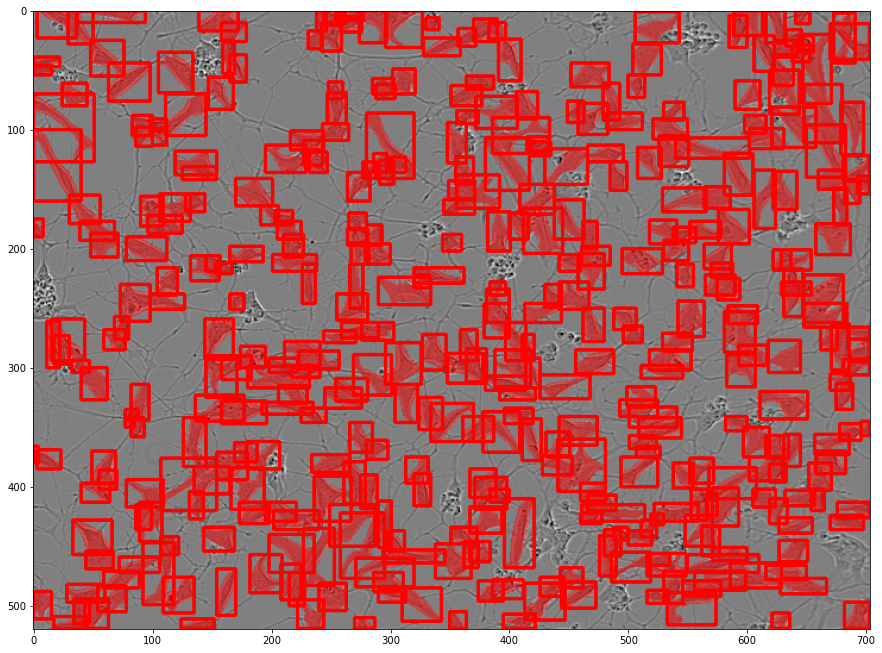

In [23]:
plot_image_annotations(image=img, masks=masks, bboxes=bboxes, labels=labels)

In [24]:
train_augmentations = A.Compose([
    A.RandomResizedCrop(640, 640, scale=(0.8, 1.0), ratio=(0.9, 1.3)),
    A.HorizontalFlip(),
    A.RandomRotate90()
], bbox_params={"format": "pascal_voc", "min_area": 0, "min_visibility": 0, 'label_fields': ['labels']})

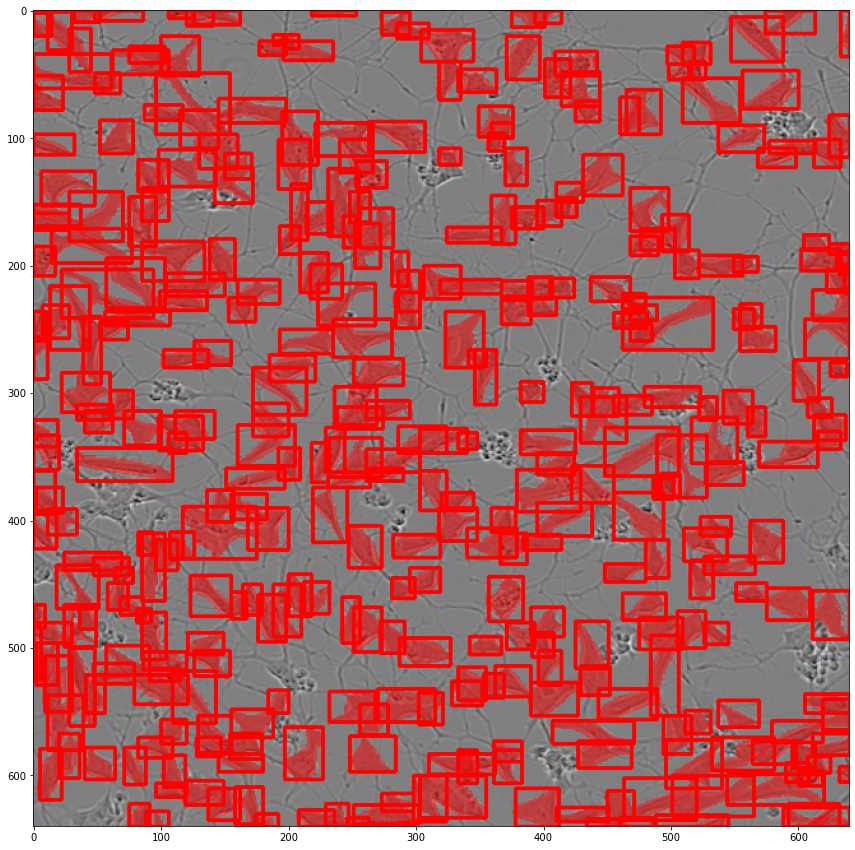

In [25]:
plot_image_annotations(image=img, masks=masks, bboxes=bboxes, labels=labels, aug=train_augmentations)

In [26]:
class CellSegData(torch.utils.data.Dataset):
    def __init__(self, root, df, split='train', aug=None):
        self.augmentations = aug
        
        train, test = train_test_split(df['id'].unique(), train_size=0.9)
        if split=='train':
            self.dataset = train
        else:
            self.dataset = test
            
        self.dict_df = {img_id:df[df['id']==img_id] for img_id in tqdm(self.dataset)}
        self.root = root
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img_id = self.dataset[index]
        image = cv2.imread(os.path.join(self.root, img_id+'.png'))
        
        info = self.dict_df[img_id]
        n_objects = len(info['annotation'])
                
        labels, rles = get_targets_mask(info, img_id)
        
        masks = []
        for mask in rles:
            decoded_mask = decode_rle_mask(rle_mask=mask, shape=img.shape)
            masks.append(decoded_mask)
            
        bboxes = get_bboxes_from_mask(masks)
        
        if self.augmentations is not None:
            augmented = self.augmentations(image=image, masks=masks, bboxes=bboxes,
                            labels=labels)
            image = augmented['image']
            masks = augmented['masks']
            bboxes = augmented['bboxes']
            bboxes = np.stack(bboxes).astype(int)
        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([index])
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # This is the required target for the Mask R-CNN
        target = {
            'boxes': bboxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        return torch.Tensor(image)/255, target

In [27]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [28]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [29]:
# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=4,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [30]:
from engine import train_one_epoch, evaluate
import utils

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
# use our dataset and defined transformations
dataset = CellSegData('data/train', train_df, 'train', train_augmentations)
dataset_test = CellSegData('data/train', train_df, 'test', train_augmentations)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4)

# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")